In [11]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [12]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [13]:
df2.iloc[:, 9:15]

,A7,A8,A9,A10,A11,A12
0,0.0938,0.0933,0.0947,0.094,0.0945,0.0923
1,0.0933,0.0932,0.0948,0.0937,0.0937,0.0923
2,0.0932,0.0933,0.0948,0.0939,0.0939,0.0927
3,0.0934,0.0935,0.095,0.0941,0.0941,0.0926
4,0.0938,0.0939,0.0954,0.0945,0.0945,0.0929
...,...,...,...,...,...,...
337,0.5901,0.6007,0.5678,0.5227,0.5631,0.308
338,0.5898,0.6002,0.5683,0.5222,0.5616,0.3055
339,0.5889,0.5999,0.5681,0.5221,0.5621,0.3051
340,0.5888,0.5992,0.5675,0.5211,0.561,0.3032


In [14]:
c=-1
P_exp=np.array(df2.iloc[:, 9:14])
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(5, 231399.5)

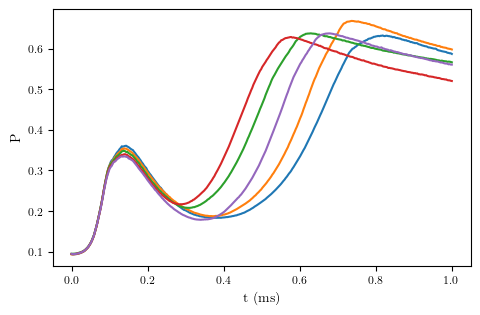

In [15]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [16]:
N_f = 100 # Number of residual point
N_d = 800 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx1 = T_star[::len(T_exp)]
uu1 = P_star[::len(T_exp)]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
p_train = np.concatenate((uu1,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)

In [17]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, m, W_p, b_p, W_phip, b_phip, W_phia, b_phia):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)

        lnp=u[:,0:1]
        lns=u[:,1:2]
        lna=u[:,2:3]

        p=tf.exp(lnp)
        s=tf.exp(lns)
        a=tf.exp(lna)

        
        phi_p=net(tf.concat([p, s, a],1), W_phip, b_phip)
        phi_a=net(tf.concat([p, a],1), W_phia, b_phia)

    p_t = tape1.gradient(p, t) 
    s_t = tape1.gradient(s, t) 
    a_t = tape1.gradient(a, t) 

    f_p = p_t - phi_p
    f_a = a_t - phi_a
    f_s = s_t + m[0]*p*s
    
    return f_p, f_s, f_a


#@tf.function()
@tf.function()
def train_step(W_p, b_p, W_phip, b_phip, W_phia, b_phia, X_u_train_tf, p_train_tf, X_f_train_tf, lambda_r, lambda_b, m, opt):
    
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phip, b_phip, W_phia, b_phia, lambda_r, lambda_b])
        u_nn = net(t_u, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p, f_s, f_a = net_f(t_f, m, W_p, b_p, W_phip, b_phip, W_phia, b_phia)

        loss_p = tf.square(lambda_b*(p_nn - p_train_tf))
        loss_fp = tf.square(lambda_r*f_p) 
        loss_fs = tf.square(lambda_r*f_s) 
        loss_fa = tf.square(lambda_r*f_a) 

        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs) + tf.reduce_mean(loss_fa)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phip = tape.gradient(loss, train_vars(W_phip, b_phip))
    grads_phia = tape.gradient(loss, train_vars(W_phia, b_phia))

    # grads_m = tape.gradient(loss, m)

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phip, train_vars(W_phip, b_phip)))
    opt.apply_gradients(zip(grads_phia, train_vars(W_phia, b_phia)))
    # opt.apply_gradients(zip(grads_m, m))
   
    return loss, tf.reduce_mean(loss_p), tf.reduce_mean(loss_fp), tf.reduce_mean(loss_fs), tf.reduce_mean(loss_fa)



layers = [1, 50, 50, 3]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [3, 50, 50, 1]

W_phip = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phip = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 50, 50, 1]

W_phia = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phia = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lambda_r, lambda_b = loss_weight(N_f, N_d)
m = [tf.Variable(tf.ones([1,1])*0.391, dtype=tf.float32)]

In [18]:
lr = 1e-4
# Nmax = 15000
# Nmax = 150000
Nmax=10**5
# Nmax=60000



optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_fisa = []


while n <= Nmax:
    loss_, loss_p, loss_fp, loss_fs, loss_fa = train_step(W_p, b_p, W_phip, b_phip, W_phia, b_phia, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, m, optimizer)
    
    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    loss_fisa.append(loss_fa)



    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        print(f"Physicial loss of a is: {loss_fa}")


    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 380479.75
Data loss is: 380479.375
Physicial loss of p is: 0.060023143887519836
Physicial loss of s is: 0.042344581335783005
Physicial loss of a is: 0.28055378794670105
Iteration is: 10
Total loss is: 364141.15625
Data loss is: 364140.90625
Physicial loss of p is: 0.008805201388895512
Physicial loss of s is: 0.050625789910554886
Physicial loss of a is: 0.20153306424617767
Iteration is: 20
Total loss is: 342860.375
Data loss is: 342860.25
Physicial loss of p is: 0.006923652719706297
Physicial loss of s is: 0.04679582267999649
Physicial loss of a is: 0.09416572749614716
Iteration is: 30
Total loss is: 318038.75
Data loss is: 318038.6875
Physicial loss of p is: 0.0019162106327712536
Physicial loss of s is: 0.03916958346962929
Physicial loss of a is: 0.02725437842309475
Iteration is: 40
Total loss is: 291188.65625
Data loss is: 291188.625
Physicial loss of p is: 0.0008644562331028283
Physicial loss of s is: 0.037499841302633286
Physicial loss of a is: 0.00525

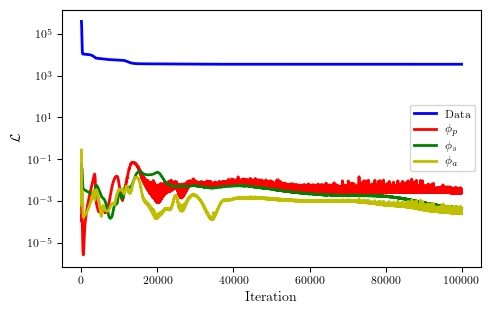

In [19]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]
loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]
loss_phia_list = [loss_fisa[i].numpy() for i in range(0,Nmax)]


plt.semilogy(it, np.asarray(loss_data_list), 'b-', linewidth = 2, label = 'Data')  
plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, label = '$\phi_p$')    
plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, label = '$\phi_s$')    
plt.semilogy(it, np.asarray(loss_phia_list), 'y-', linewidth = 2, label = '$\phi_a$')       



plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [20]:
m

[<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.391]], dtype=float32)>]

In [21]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]
lna=u_pred[:,2:3]

p=tf.exp(lnp)
s=tf.exp(lns)
a=tf.exp(lna)
phi_p = predict(tf.concat([p, s, a],1), W_phip, b_phip)
phi_a = predict(tf.concat([p, a],1), W_phia, b_phia)

phi_s=np.array(p*s*m[0])


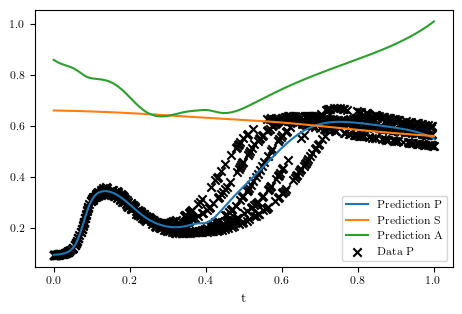

In [22]:
plt.plot(T_star_tf, p, label='Prediction P')
plt.plot(T_star_tf, s, label='Prediction S')
plt.plot(T_star_tf, a, label='Prediction A')


# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

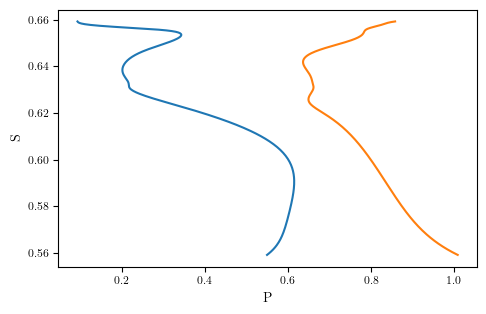

In [23]:
plt.plot(p, s)
plt.plot(a, s)

plt.xlabel('P')
plt.ylabel('S')
# plt.savefig('figures/P_phi.pdf')
plt.show()


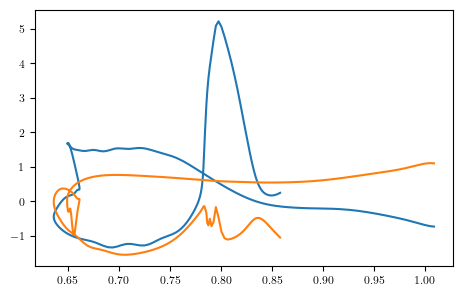

In [24]:
plt.plot(a, phi_p, label='Prediction')
plt.plot(a, phi_a, label='Prediction')



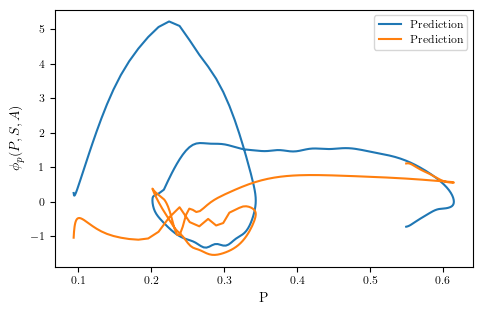

In [25]:
plt.plot(p, phi_p, label='Prediction')
plt.plot(p, phi_a, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P,S,A)$')
# plt.savefig('figures/phi.pdf')
plt.show()

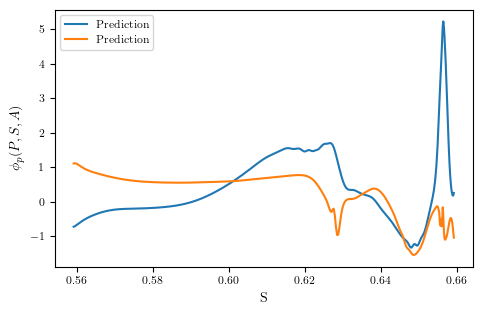

In [26]:
plt.plot(s, phi_p, label='Prediction')
plt.plot(s, phi_a, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('S')
plt.ylabel('$\phi_p(P,S,A)$')
# plt.savefig('figures/phi.pdf')
plt.show()

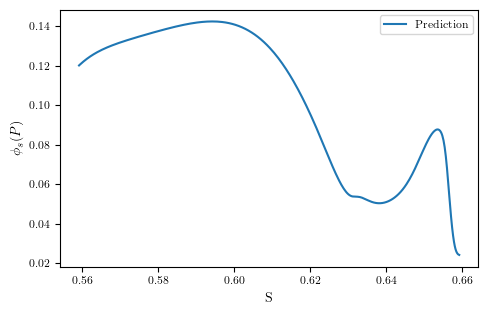

In [27]:
plt.plot(s, phi_s, label='Prediction')
# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('S')
plt.ylabel('$\phi_s(P)$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [28]:
Nt=10000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
S_int=np.zeros(Nt)
A_int=np.zeros(Nt)


dt=0.0001

T_int[0]=0
# P_int[0]=np.mean(uu1) #Initial conditions
P_int[0]=np.array(p[0]) #Initial conditions
S_int[0]=np.array(s[0]) #Initial conditions
A_int[0]=np.array(a[0]) #Initial conditions



for i in range(1,Nt):

    PSA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)

    PHI_P=predict(PSA , W_phip, b_phip)
    PHI_A=predict(PA , W_phia, b_phia)

    P_int[i]=P_int[i-1]+PHI_P*dt
    A_int[i]=A_int[i-1]+PHI_A*dt
    S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*np.array(m[0])*dt
    T_int[i]=T_int[i-1]+dt

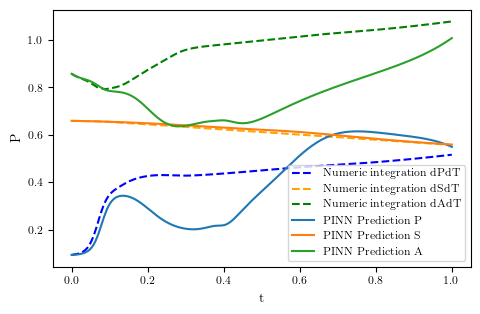

In [29]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, A_int, color='green', linestyle='--', label='Numeric integration dAdT')



plt.plot(T_star_tf, p, label='PINN Prediction P')
plt.plot(T_star_tf, s, label='PINN Prediction S')
plt.plot(T_star_tf, a, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

# Symbolic Regresion

In [24]:
# Create and train the PySR model
model_phi = PySRRegressor(
    niterations=500,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    # unary_operators=["inv(x) = 1/x"],
    # extra_sympy_mappings={"inv": lambda x: 1 / x},
    # constraints={"/": (-1, 1)},
    # complexity_of_operators={"/": 2},
    parsimony=0.00001,
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)

In [25]:
# Fit phi
model_phi.fit(tf.concat([p, s],1), phi_pred)
print(model_phi)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.330e+05
Head worker occupation: 29.9%
Progress: 545 / 7500 total iterations (7.267%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.719e+00  1.594e+01  y = x₁
3           4.513e+00  2.231e-02  y = x₁ * 2.2107
5           3.319e+00  1.537e-01  y = (x₁ * 14.066) + -4.5759
7           2.724e+00  9.868e-02  y = (-4.7893 * x₀) + (x₁ * 11.093)
9           2.447e+00  5.368e-02  y = ((-98.555 + (x₁ * 151.99)) * x₁) + 14.641
11          6.685e-01  6.488e-01  y = ((38.873 * x₁) + ((x₀ + -0.36154) * -31.833)) * x₀
13          6.304e-01  2.937e-02  y = ((((x₀ + -0.41423) * -33.14) + (38.604 * x₁)) * x₀) + -0.8...
                                  1758
15          6.136e-01  1.347e-02  y = (x₀ * (((x₀ + -0.44546) * -36.131) + ((39.684 * x₁) + x₁))...
                                  ) + -1.4102
17          6.025e-01  9.119e-03  y = (x₀ + ((

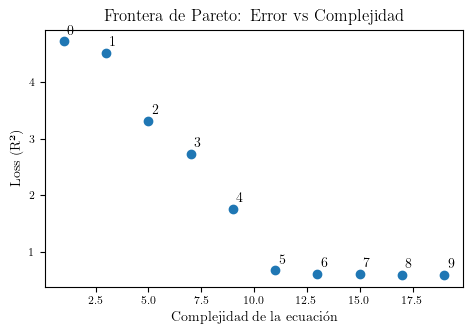

In [26]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

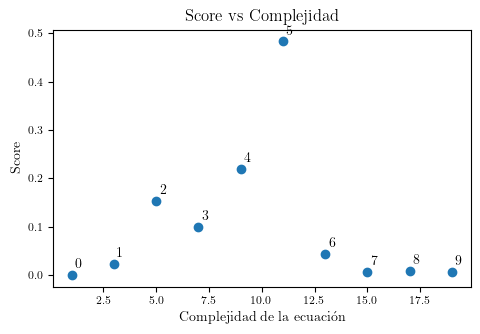

In [27]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [28]:
chose=5
expr=model_phi.sympy(chose)
expr
sympy.expand(expr)

-31.679077*x0**2 + 38.66269*x0*x1 + 11.4634953441741*x0

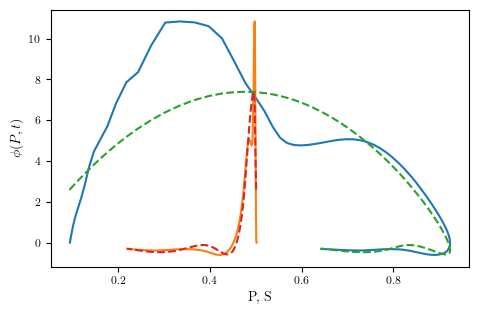

In [29]:
symb1=model_phi.predict(tf.concat([p, s],1),chose)
plt.plot(tf.concat([p, s],1), phi_pred, label='PINN prediction')
plt.plot(tf.concat([p, s],1), symb1, linestyle='--', label='Symbolic regresion')

plt.xlabel('P, S')
plt.ylabel('$\phi (P,t)$')
plt.show()

In [30]:
Nt=10000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)
S_symb=np.zeros(Nt)

dt=0.0001

P_symb[0]=np.mean(uu1) #Initial conditions
S_symb[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions
T_symb[0]=0
for i in range(1,Nt):
    PS_p=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb[i]=P_symb[i-1]+model_phi.predict(PS_p,chose)*dt
    S_symb[i]=S_symb[i-1]-P_symb[i-1]*np.array(m[0])*dt
    T_symb[i]=T_symb[i-1]+dt

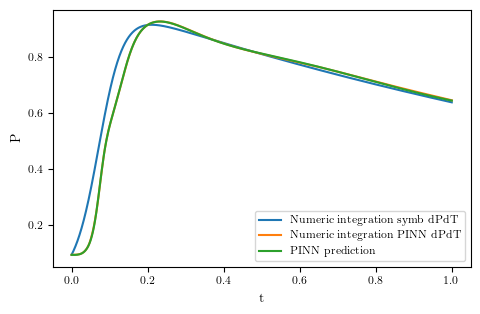

In [35]:
plt.plot(T_symb, P_symb, label='Numeric integration symb dPdT')
plt.plot(T_int, P_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, p, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

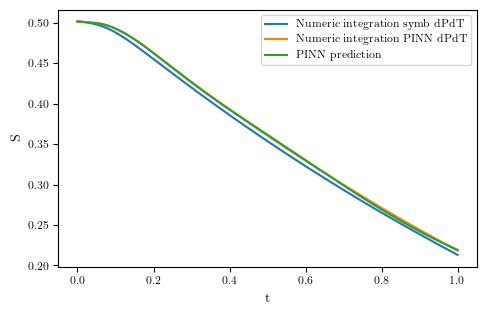

In [36]:
plt.plot(T_symb, S_symb, label='Numeric integration symb dPdT')
plt.plot(T_int, S_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, s, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('S')
plt.legend()
plt.show()